In [1]:
import TurbPy as tb
from TurbPy.imports import *

In [2]:
# deck = 'KH_Lv1di/'
# deck = 'turb2/'
# deck = 'turb_vth0.01/'
# deck = 'KH_test/'
# deck = 'KH_beta0.1/'
# deck = 'KH_subash/'
# deck = 'KH_new/'
# deck = 'KH_800ppc/'
# deck = 'KH_400ppc_200wci2/'
deck = 'KH_200ppc_200wci/'


dirs = '/pscratch/sd/g/goodwill/' + deck

figs = '/pscratch/sd/g/goodwill/Fig/' + deck

info = tb.get_vpic_info(dirs)
times = tb.get_times(dirs)
en_out = tb.read_energies(dirs)/(info['Lx/de'] * info['Ly/de'] * info['Lz/de'])

twci_out = np.linspace(0, times[-1] * info['dt*wci'], len(en_out['EM']))
twci = np.linspace(0, times[-1] * info['dt*wci'], len(times))

twce_out = np.linspace(0, times[-1] * info['dt*wce'], len(en_out['EM']))
twce = np.linspace(0, times[-1] * info['dt*wce'], len(times))

lx = np.linspace(0, info['Lx/di'], int(info['nx']))
ly = np.linspace(0, info['Ly/di'], int(info['ny']))

cut = info['Lx/di']/100
lxc = np.linspace(cut, info['Lx/di'] - cut, int(1080))
# lyc = np.linspace(, info['Lx/di'] - cut, int(1))

In [3]:
def pderiv(ar,dx=1.,ax=0,order=2,smth=None):
   """
      pderiv gives the first partial derivative
      of a periodic array along a given axis.

      Inputs:
         ar - The input array
         dx - Grid spacing, defaults to 1.
         ax - Axis along which to take the derivative
         order - Order of accuracy, (1,2) defaults to 2

      Output:
         dar - The derivative array
   """
   ar = np.array(ar)
   if smth is not None:
      ar = gf(ar,sigma=smth)
   if order == 1:
      dar = (np.roll(ar,-1,axis=ax)-ar)/dx
   elif order == 2:
      dar = (np.roll(ar,-1,axis=ax)-np.roll(ar,1,axis=ax))/(2*dx)
   
   return dar 

In [4]:
def load_hydro_fil(dirs, time_step, species = 'electron'):
    hydro_file = h5py.File(dirs+"filter_hdf5/T."+str(time_step)+ "/" + species + "_"+str(time_step)+".h5", 'r')
    # field_file = h5py.File(dirs+"filter_hdf5/T."+str(time_step)+"/fields_" + str(time_step)+".h5", 'r')
    var_dict = {}
    hydro_vars = ['jx', 'jy', 'jz', 'px', 'py', 'pz', 'txx', 'tyy', 'tzz', 'txy', 'tzx', 'tyz', 'rho']
    for i in hydro_vars:
        dset = hydro_file[i]
        var_dict[i] = np.array(dset[:,:])
    return (var_dict)

def load_hydro(dirs, time_step, species = 'electron'):
    hydro_file = h5py.File(dirs+"hydro_hdf5/T."+str(time_step)+"/hydro_" + species + "_"+str(time_step)+".h5", 'r')
    var_dict = {}
    hydro_vars = ['jx', 'jy', 'jz', 'px', 'py', 'pz', 'txx', 'tyy', 'tzz', 'txy', 'tzx', 'tyz', 'rho']
    for i in hydro_vars:
        dset = hydro_file['Timestep_'f'{time_step}'][i]
        
        var_dict[i] = np.array(dset[:,:,0])
    return (var_dict)

In [5]:
def get_vpic_info(dirs):
    """
    Get information of the VPIC simulation
    input:
    dirs: string; place where info file is located
    output:
    vpic_info: dict; returns integer given string
    """
    with open(dirs+'info') as f:
        content = f.readlines()
    f.close()
    vpic_info = {}
    for line in content[1:]:
        if "=" in line:
            line_splits = line.split("=")
        elif ":" in line:
            line_splits = line.split(":")

        tail = line_splits[1].split("\n")
        vpic_info[line_splits[0].strip()] = float(tail[0])
    return vpic_info

In [6]:
def ps_calc(dirs, timestep, species, kfilt = True, norm = False):
    if kfilt == True:
      ds = load_hydro_fil(dirs,timestep,species)
    if kfilt == False:
      ds = load_hydro(dirs,timestep,species)
    vpic_info = get_vpic_info(dirs)

    dx = vpic_info['dx/de']
    dy = vpic_info['dy/de']
    mi_me = vpic_info['mi/me']


    ux = (ds['jx']/ds['rho'])
    uy = (ds['jy']/ds['rho'])
    uz = (ds['jz']/ds['rho'])

    # pxx = np.array(ds['txx'] - (ds['jx']/ds['rho'])*ds['px'])
    # pyy = np.array(ds['tyy'] - (ds['jy']/ds['rho'])*ds['py'])
    # pzz = np.array(ds['tzz'] - (ds['jz']/ds['rho'])*ds['pz'])
    # pxy = np.array(ds['txy'] - (ds['jx']/ds['rho'])*ds['py'])


    # pxx = np.array(ds['txx'] - ux*ds['px'])
    # pyy = np.array(ds['tyy'] - uy*ds['py'])
    # pzz = np.array(ds['tzz'] - uz*ds['pz'])
    # pxy = np.array(ds['txy'] - ()*ds['py'])

    pxx = (ds['txx'] - ux*ds['px'])[100:1180,:]
    pyy = (ds['tyy'] - uy*ds['py'])[100:1180,:]
    pzz = (ds['tzz'] - uz*ds['pz'])[100:1180,:]
    pxy = (ds['txy'] - ux*ds['py'])[100:1180,:]; 
    pxz = (ds['tzx'] - ux*ds['pz'])[100:1180,:]; 
    pyz = (ds['tyz'] - uy*ds['pz'])[100:1180,:]

    # pxx = (ds['txx'] - ux*ds['px'])
    # pyy = (ds['tyy'] - uy*ds['py'])
    # pzz = (ds['tzz'] - uz*ds['pz'])
    # pxy = (ds['txy'] - ux*ds['py']); 
    # pxz = (ds['tzx'] - ux*ds['pz']); 
    # pyz = (ds['tyz'] - uy*ds['pz'])


    ux = (ds['jx']/ds['rho'])[100:1180,:]
    uy = (ds['jy']/ds['rho'])[100:1180,:]
    uz = (ds['jz']/ds['rho'])[100:1180,:]

    # pyx = ds['txy'] - uy*ds['px']; pzx = ds['tzx'] - uz*ds['px']; pzy = ds['tyz'] - uz*ds['py']
    # pyx = np.array(txy - (jy/rho)*px)
    # pxz = np.array(ds['tzx'] - (ds['jx']/ds['rho'])*ds['pz'])
    # pzx = np.array(tzx - (jz/rho)*px)
    # pyz = np.array(ds['tyz'] - (ds['jy']/ds['rho'])*ds['pz'])
    # pzy = np.array(tyz - (jz/rho)*py)
    # if kfilt != None:
    #     pxx = kfilter(np.array(ds['txx'] - (ds['jx']/ds['rho'])*ds['px']), kfilt)
    #     pyy = kfilter(np.array(ds['tyy'] - (ds['jy']/ds['rho'])*ds['py']), kfilt)
    #     pzz = kfilter(np.array(ds['tzz'] - (ds['jz']/ds['rho'])*ds['pz']), kfilt)
    #     pxy = kfilter(np.array(ds['txy'] - (ds['jx']/ds['rho'])*ds['py']), kfilt)
    #     pxz = kfilter(np.array(ds['tzx'] - (ds['jz']/ds['rho'])*ds['px']), kfilt)
    #     pyz = kfilter(np.array(ds['tyz'] - (ds['jy']/ds['rho'])*ds['pz']), kfilt)



    # particle_mass = 1
    # if species == 'ion':
    #     particle_mass = mi_me
    #     ux=ds['jx']/ds['rho']
    #     uy=ds['jy']/ds['rho']
    #     uz=ds['jz']/ds['rho']
        # ux = ds['px']/np.abs(ds['rho'])/particle_mass
        # uy = ds['py']/np.abs(ds['rho'])/particle_mass
        # uz = ds['pz']/np.abs(ds['rho'])/particle_mass
    # if species == 'electron':
    #     particle_mass = 1
    #     ux=ds['jx']/ds['rho']
    #     uy=ds['jy']/ds['rho']
    #     uz=ds['jz']/ds['rho']
        # ux = ds['px']/np.abs(ds['rho'])/particle_mass
        # uy = ds['py']/np.abs(ds['rho'])/particle_mass
        # uz = ds['pz']/np.abs(ds['rho'])/particle_mass
    # if kfilt != None:
    #     ux = kfilter(ds['px']/np.abs(ds['rho'])/particle_mass, kfilt)
    #     uy = kfilter(ds['py']/np.abs(ds['rho'])/particle_mass, kfilt)
    #     uz = kfilter(ds['pz']/np.abs(ds['rho'])/particle_mass, kfilt)

    dux_dx = pderiv(ux,dx=dx,ax=0,order=2,smth=None)
    duy_dx = pderiv(uy,dx=dx,ax=0,order=2,smth=None)
    duz_dx = pderiv(uz,dx=dx,ax=0,order=2,smth=None)
    dux_dy = pderiv(ux,dx=dy,ax=1,order=2,smth=None)
    duy_dy = pderiv(uy,dx=dy,ax=1,order=2,smth=None)
    duz_dy = pderiv(uz,dx=dy,ax=1,order=2,smth=None)    

    
    # dux_dx = (np.roll(ux,-1,axis=0)-np.roll(ux,1,axis=0))/(2 * dx)
    # duy_dx = (np.roll(uy,-1,axis=0)-np.roll(uy,1,axis=0))/(2 * dx)
    # duz_dx = (np.roll(uz,-1,axis=0)-np.roll(uz,1,axis=0))/(2 * dx)
    
    # dux_dy = (np.roll(ux,-1,axis=1)-np.roll(ux,1,axis=1))/(2 * dy)
    # duy_dy = (np.roll(uy,-1,axis=1)-np.roll(uy,1,axis=1))/(2 * dy)
    # duz_dy = (np.roll(uz,-1,axis=1)-np.roll(uz,1,axis=1))/(2 * dy)

    theta = np.array(dux_dx + duy_dy)

    Dxx = np.array(dux_dx) - (1/3)*theta 

    Dyy = np.array(duy_dy) - (1/3)*theta
    Dzz = 0 - (1/3)*theta
    
    Dxy = np.array((1/2)*(dux_dy + duy_dx))
    Dxz = np.array((1/2)*(duz_dx))
    Dyz = np.array((1/2)*(duz_dy))

    p = np.array(pxx + pyy + pzz)/3
    PIxx = pxx - p
    PIyy = pyy - p
    PIzz = pzz - p
    ptheta = - p * theta
    pid = -(PIxx*Dxx+PIyy*Dyy+PIzz*Dzz+ 2.* np.array(pxy*Dxy+pxz*Dxz+pyz*Dyz))
    if norm == True:
        pid_rms = np.sqrt(np.mean(pid**2))
        pid = pid/pid_rms

        pth_rms = np.sqrt(np.mean(ptheta**2))
        ptheta = ptheta/pth_rms
    return PIxx, PIyy, PIzz, pxy, pxz, pyz, Dxx, Dxy, Dxz, Dyy, Dyz, Dzz

In [7]:
PIxx, PIyy, PIzz, pxy, pxz, pyz, Dxx, Dxy, Dxz, Dyy, Dyz, Dzz = ps_calc(dirs, times[500], 'ion')

In [8]:
print(np.shape(Dxx))
print(np.shape(Dyy))
print(np.shape(Dzz))

(1080, 2560)
(1080, 2560)
(1080, 2560)


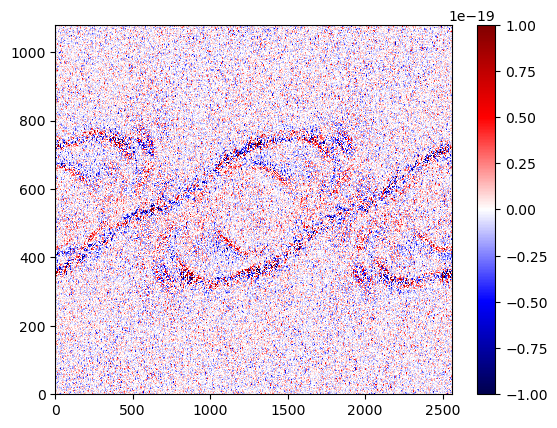

In [9]:
plt.pcolormesh((Dxx + Dyy + Dzz)/3, cmap = 'seismic', vmin = -1e-19, vmax = 1e-19)
plt.colorbar()

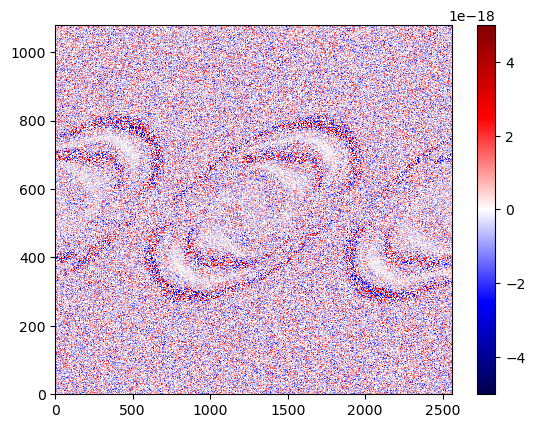

In [10]:
plt.pcolormesh((PIxx + PIyy + PIzz)/3, cmap = 'seismic', vmin = -5e-18, vmax = 5e-18)
plt.colorbar()

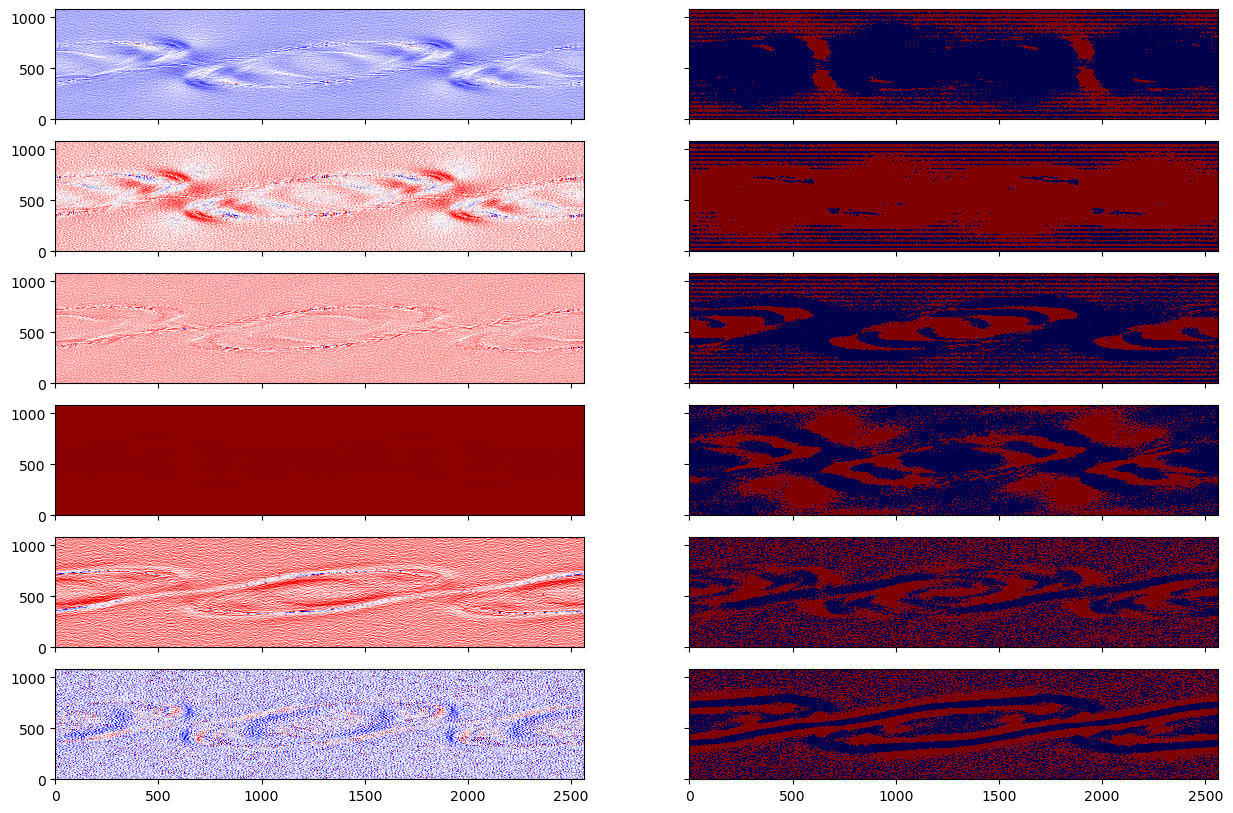

In [11]:
fig, ax = plt.subplots(6, 2, figsize = (15, 10), sharex= True, sharey = True)

ax[0,0].pcolormesh(Dxx, cmap = 'seismic')
# , vmin = -5e-15, vmax = 5e-15)
ax[1,0].pcolormesh(Dyy, cmap = 'seismic')
# , vmin = -5e-15, vmax = 5e-15)
ax[2,0].pcolormesh(Dzz, cmap = 'seismic')
# , vmin = -5e-15, vmax = 5e-15)
ax[3,0].pcolormesh(Dxy, cmap = 'seismic')
# , vmin = -5e-15, vmax = 5e-15)
ax[4,0].pcolormesh(Dxz, cmap = 'seismic')
# , vmin = -5e-15, vmax = 5e-15)
ax[5,0].pcolormesh(Dyz, cmap = 'seismic')
# , vmin = -5e-15, vmax = 5e-15)


ax[0,1].pcolormesh(PIxx, cmap = 'seismic', vmin = -5e-15, vmax = 5e-15)
ax[1,1].pcolormesh(PIyy, cmap = 'seismic', vmin = -5e-15, vmax = 5e-15)
ax[2,1].pcolormesh(PIzz, cmap = 'seismic', vmin = -5e-15, vmax = 5e-15)
ax[3,1].pcolormesh(pxy , cmap = 'seismic', vmin = -5e-15, vmax = 5e-15)
ax[4,1].pcolormesh(pxz , cmap = 'seismic', vmin = -5e-15, vmax = 5e-15)
ax[5,1].pcolormesh(pyz , cmap = 'seismic', vmin = -5e-15, vmax = 5e-15)

In [12]:
data = dirs + 'data/'
ps = pd.read_csv(data + 'PS_av.csv')

(0.0, 10.0)

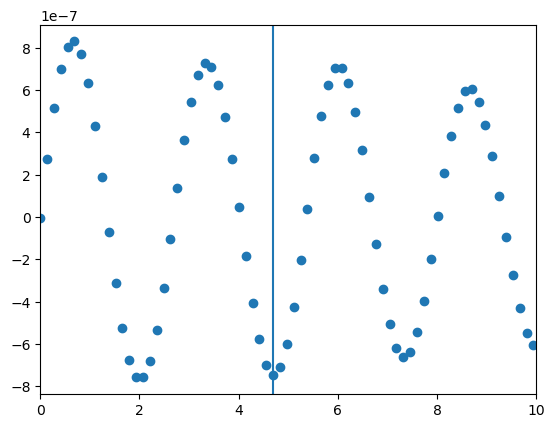

In [13]:
plt.scatter(twci, ps['pidi'])
plt.axvline(4.7)
plt.xlim(0,10)

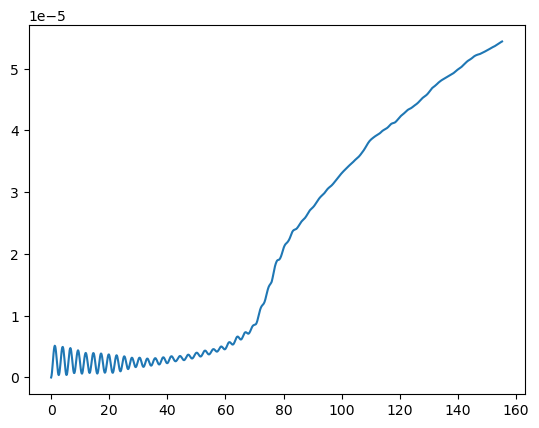

In [14]:
plt.plot(twci, np.cumsum(ps['pidi']))

In [15]:
t = 34
print(twci[t])
pthi, pidi = tb.ps_calc(dirs, times[t], 'ion')
print(np.average(pidi))

4.695631200000001
-7.441135832597494e-07


In [16]:
PIxx, PIyy, PIzz, pxy, pxz, pyz, Dxx, Dxy, Dxz, Dyy, Dyz, Dzz = ps_calc(dirs, times[t], 'ion')

In [17]:
pid = -(PIxx*Dxx+PIyy*Dyy+PIzz*Dzz+ 2.* np.array(pxy*Dxy+pxz*Dxz+pyz*Dyz))
print(np.average(pid))

-7.441135832597494e-07


In [18]:
PIxx_av = np.average(PIxx)
PIyy_av = np.average(PIyy)
PIzz_av = np.average(PIzz)
pxy_av = np.average(pxy)
pxz_av = np.average(pxz)
pyz_av = np.average(pyz)
Dxx_av = np.average(Dxx)
Dxy_av = np.average(Dxy)
Dxz_av = np.average(Dxz)
Dyy_av = np.average(Dyy)
Dyz_av = np.average(Dyz)
Dzz_av = np.average(Dzz)

In [19]:
print('Pixx = 'f'{PIxx_av}')
print('Piyy = 'f'{PIyy_av}')
print('Pizz = 'f'{PIzz_av}')
print('pxy  = 'f'{pxy_av}')
print('pxz  = 'f'{pxz_av}')
print('pyz  = 'f'{pyz_av}')
print('Dxx  = 'f'{Dxx_av}')
print('Dxy  = 'f'{Dxy_av}')
print('Dxz  = 'f'{Dxz_av}')
print('Dyy  = 'f'{Dyy_av}')
print('Dyz  = 'f'{Dyz_av}')
print('Dzz  = 'f'{Dzz_av}')

Pixx = -0.000588236897431352
Piyy = 0.0006483784357191714
Pizz = -6.014153828781895e-05
pxy  = 0.0004204670867125156
pxz  = 1.3911093655664158e-05
pyz  = -8.265419303126867e-06
Dxx  = 0.0
Dxy  = -6.167905692361981e-20
Dxz  = 2.509727251123853e-23
Dyy  = -2.4093381610788987e-22
Dyz  = -5.058668990546516e-24
Dzz  = 5.62178904251743e-22


In [20]:
PIxx_Dxx = np.average(PIxx * Dxx)
PIyy_Dyy = np.average(PIyy * Dyy)
PIzz_Dzz = np.average(PIzz * Dzz)
pxy_Dxy  = np.average(pxy * Dxy)
pxz_Dxz  = np.average(pxz * Dxz)
pyz_Dyz  = np.average(pyz * Dyz)

In [21]:
print(PIxx_Dxx)
print(PIyy_Dyy)
print(PIzz_Dzz)
print(pxy_Dxy)
print(pxz_Dxz)
print(pyz_Dyz)

3.044079784419954e-09
2.1154720165692538e-09
9.676574680262492e-11
3.6961112833605254e-07
-7.313379293654148e-11
-1.0936168713704033e-10


In [22]:
pid_av = -(PIxx_av*Dxx_av+PIyy_av*Dyy_av+PIzz_av*Dzz_av+ 2.* np.array(pxy_av*Dxy_av+pxz_av*Dxz_av+pyz_av*Dyz_av))

In [23]:
print(pid_av)

5.2057271461536753e-23
